In [1]:
#Import knižníc
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import re
import matplotlib.pyplot as plt

/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
#Nacitanie datasetu
df = pd.read_csv('data/245k_tweets.csv')

In [3]:
def clean_text(text):
    #Previesť text na malé písmená
    text = text.lower()
    
    #Odstránenie adries URL
    text = re.sub(r'http\S+', '', text)
    
    #Odstránenie hashtagov (iba symbol „#“, text ponechajte)
    text = re.sub(r'#', '', text)
    
    #Odstránenie špeciálnych znakov a čísel
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    
    #Odstránenie zbytočných medzier
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
#Zápis očistených údajov do nového stĺpca
df['clearcontent'] = df['content'].apply(clean_text)

In [6]:
#Definovanie hyperparametrov
MAX_LEN = 128
BATCH_SIZE = 16

In [7]:
#Stiahnutie tokenizéra
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
#Vytvorenie triedy pre dátasety
class PredictionDataset(Dataset):
        def __init__(self, data, tokenizer, max_len):
            self.data = data
            self.tokenizer = tokenizer
            self.max_len = max_len
    
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            content = self.data.iloc[idx]['clearcontent']
    
            encoding = self.tokenizer.encode_plus(
                content,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
    
            return {
                'content': content,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()
            }



In [13]:
#Vytváranie datasetov a súborov loadov
prediction_dataset = PredictionDataset(df, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE)

In [14]:
#Definícia zariadenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
#Stiahnutie modelu
class BERTClassifier(torch.nn.Module):
    def __init__(self, bert_model, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output

In [18]:
#Načítanie základného modelu BERT
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [19]:
#Inicializácia modelu
model = BERTClassifier(bert_model)
model.load_state_dict(torch.load('best_bert_model.pth'))  # Завантаження натренованих вагів
model = model.to(device)

In [20]:
#Funkcia pre predikcie
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

In [21]:
#Získavanie predpovedí
predictions = predict(model, prediction_loader, device)

In [22]:
#Pridanie predpovedí do datasetu
df['prediction'] = predictions

In [23]:
#Nahradenie číselných hodnôt zrozumiteľnými popismi
label_mapping = {0: 'fake', 1: 'real'}
df['prediction'] = df['prediction'].map(label_mapping)

In [25]:
#Uloženie výsledkov do nového súboru CSV
df.to_csv('data/bert_results.csv', index=False)

In [26]:
#Nacitanie datasetu
df_pred = pd.read_csv('data/bert_results.csv')

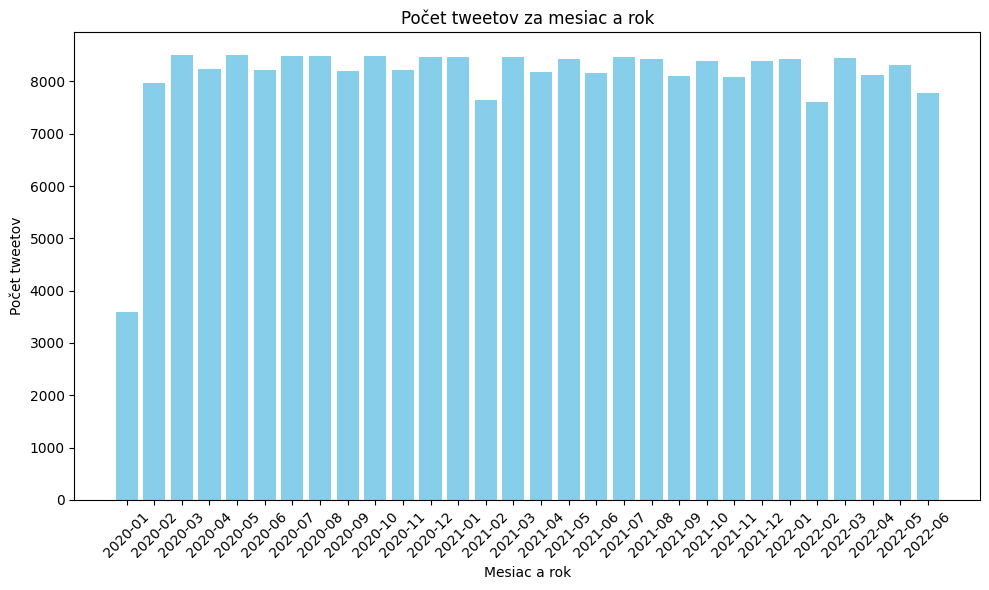

In [27]:
#Zoskupenie údajov podľa 'month_year' a spočítanie počtu tweetov
tweet_count = df_pred.groupby('month_year').size().reset_index(name='count')

#Vizualizacia počtu tweetov za kazdy mesiac
plt.figure(figsize=(10, 6))
plt.bar(tweet_count['month_year'], tweet_count['count'], color='skyblue')
plt.title('Počet tweetov za mesiac a rok')
plt.xlabel('Mesiac a rok')
plt.ylabel('Počet tweetov')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
#Odstranenie riadkov za period '2020-01'
df_pred = df_pred[df_pred['month_year'] != '2020-01']

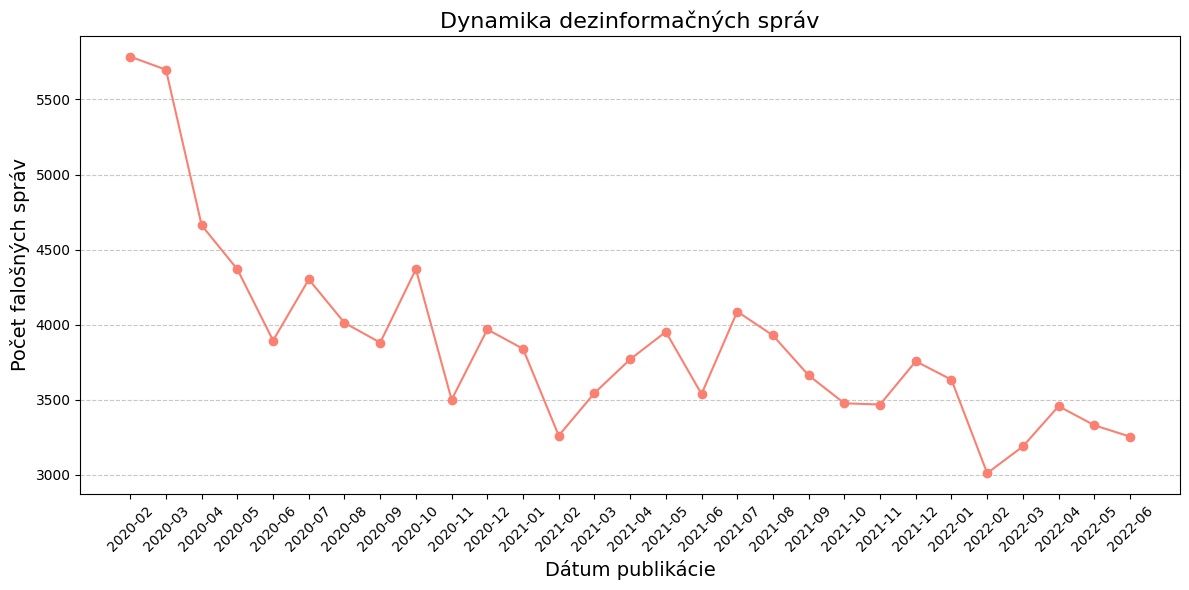

In [29]:
#Filtrovanie iba falošných postov
fake_posts = df_pred[df_pred['prediction'] == 'fake']

#Zoskupenie podľa month_year a počítanie počtu falošných postov
fake_counts = fake_posts.groupby('month_year').size().reset_index(name='count')

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(fake_counts['month_year'], fake_counts['count'], marker='o', color='salmon', linestyle='-')

plt.title('Dynamika dezinformačných správ', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Počet falošných správ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

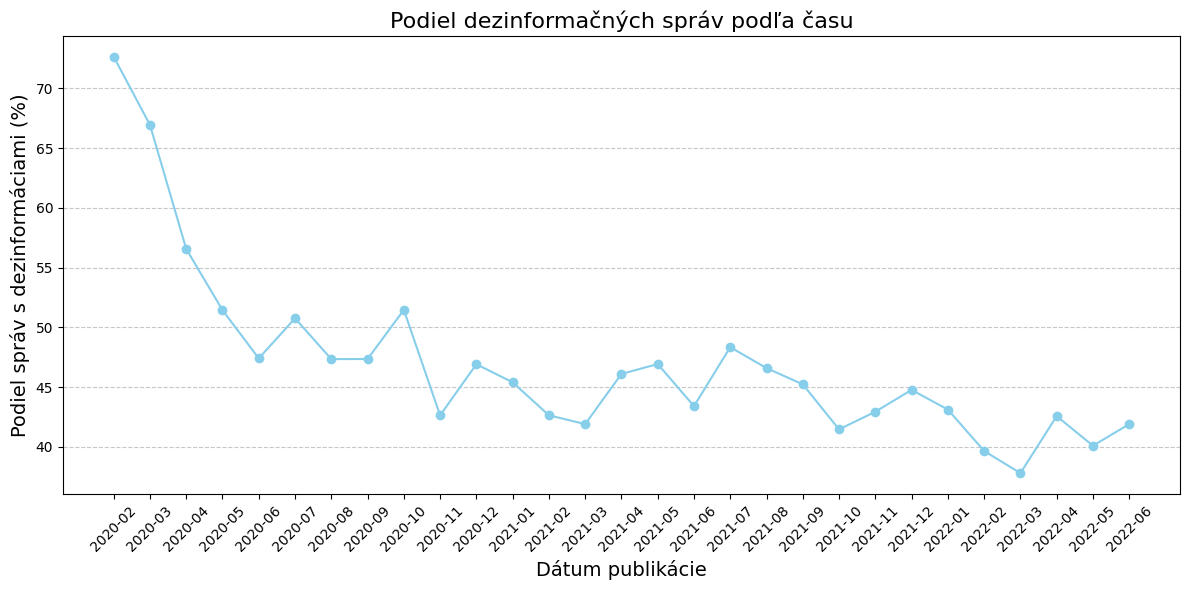

In [30]:
#Zoskupenie podľa month_year a počítanie počtu všetkých a falošných postov
grouped = df_pred.groupby('month_year').agg(
    total_posts=('prediction', 'count'),
    fake_posts=('prediction', lambda x: (x == 'fake').sum())
).reset_index()

#Výpočet percenta falošných postov za každé obdobie
grouped['fake_percentage'] = (grouped['fake_posts'] / grouped['total_posts']) * 100

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(grouped['month_year'], grouped['fake_percentage'], marker='o', color='skyblue', linestyle='-')

plt.title('Podiel dezinformačných správ podľa času', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Podiel správ s dezinformáciami (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()